This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it contains runnable code blocks and section titles, and a lot of edits made by Matthew Kehoe.

This notebook was generated for TensorFlow 2.6.

## DeepDream

<font color='blue'>DeepDream</font>  is  an  artistic  image-modification  technique  that  uses  the <font color='blue'>representations learned</font> by <font color='blue'>convolutional neural networks</font>. It was first released by Google in the summer of 2015 as an implementation written using the Caffe deep learning library (this was several months before the first public release of TensorFlow). It quickly became an internet sensation thanks to the trippy pictures it could generate (see, for example, the figure  below),  full  of  algorithmic  pareidolia  artifacts,  bird  feathers,  and  dog  eyes—a byproduct of the fact that the <font color='blue'>DeepDream convnet</font> was trained on <font color='blue'>ImageNet</font>, where dog breeds and bird species are vastly overrepresented.

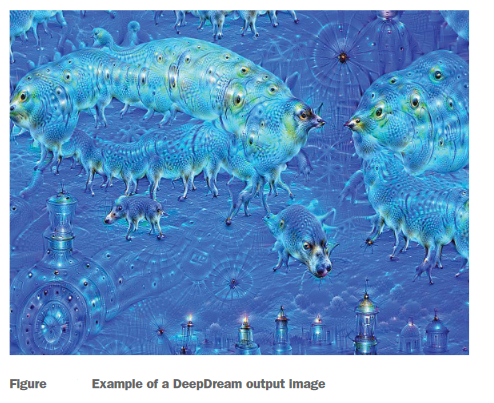

The DeepDream algorithm is <font color='blue'>almost identical</font> to the <font color='blue'>convnet filter-visualization technique</font> introduced in chapter 9, consisting of <font color='blue'>running</font> a convnet in <font color='blue'>reverse</font>: doing <font color='blue'>gradient  ascent</font>  on  the  <font color='blue'>input</font>  to  the  convnet  in  order  to  <font color='blue'>maximize  the  activation</font>  of  a
specific filter in an <font color='blue'>upper layer</font> of the convnet. DeepDream uses this same idea, with a few differences:

*   With  DeepDream,  you  try  to  <font color='blue'>maximize</font>  the  <font color='blue'>activation</font>  of  <font color='blue'>entire  layers</font>  rather than  that  of  a  specific  filter,  thus  mixing  together  visualizations  of  large  numbers of features at once.
*   You  <font color='blue'>start</font>  not  from  blank,  slightly  noisy  input,  but  rather  from  an  <font color='blue'>existing image</font>—thus the resulting effects <font color='blue'>latch on</font> to <font color='blue'>preexisting visual patterns</font>, distorting elements of the image in a somewhat artistic fashion.
* The  input  images  are  processed  at  different  scales  (called  octaves),  which improves the quality of the visualizations.

Let's make some DeepDreams.




### Implementing DeepDream in Keras

Let's  start  by  retrieving  a  test  image  to  dream  with.  We'll  use  a  view  of  the  <font color='blue'>rugged Northern California coast</font> in the <font color='blue'>winter</font>.

**Fetching the test image**

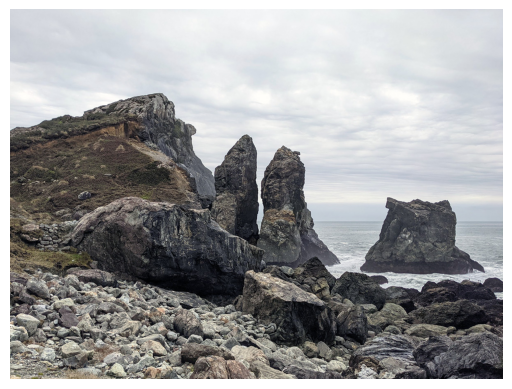

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

Next,  we  need  a  <font color='blue'>pretrained  convnet</font>.  In  Keras,  many  such  convnets  are  available: VGG16, VGG19, Xception, ResNet50, and so on, all available with weights pretrained on ImageNet. You can <font color='blue'>implement DeepDream</font> with <font color='blue'>any of them</font>, but your base model of choice will naturally affect your visualizations, because different architectures result
in  different  learned  features.  The  convnet  used  in  the  original  DeepDream  release was an <font color='blue'>Inception model</font>, and in practice, Inception is known to produce nice-looking DeepDreams, so we'll use the Inception V3 model that comes with Keras.

**Instantiating a pretrained `InceptionV3` model**

In [2]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

We'll  use  our <font color='blue'>pretrained  convnet</font>  to  create  a  <font color='blue'>feature  exactor  model</font>  that  returns  the <font color='blue'>activations</font>  of  the  various  <font color='blue'>intermediate  layers</font>,  listed  in  the  following  code.  For  each layer, we pick a <font color='blue'>scalar score</font> that <font color='blue'>weights</font> the <font color='blue'>contribution of the layer</font> to the loss we will seek  to  maximize  during  the  gradient  ascent  process.  If  you  want  a  complete  list  of layer names that you can use to pick new layers to play with, just use `model.summary()`.

**Configuring the contribution of each layer to the DeepDream loss**

In [3]:
layer_settings = {                                                              # Layers for which we try to maximize activation, as
    # "mixed4": 1.0,                                                            # well as their weight in the total loss. You can tweak
    # "mixed5": 1.5,                                                            # these setting to obtain new visual effects.
    # "mixed6": 2.0,
    # "mixed7": 2.5,
      "mixed4": 2.0,
      "mixed5": 3.5,
      "mixed6": 6.5,
      "mixed6": 8.0
}
outputs_dict = dict(                                                            # Symbolic outputs of each layer.
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)      # Model that returns the activation values for every target
                                                                                # layer (as a dict).

Next, we'll compute the <font color='blue'>loss</font>: the quantity we'll seek to <font color='blue'>maximize</font> during the <font color='blue'>gradient-ascent</font> process at each processing scale. In chapter 9, for filter visualization, we tried to maximize  the  value  of  a  specific  filter  in  a  specific  layer.  Here,  we'll  <font color='blue'>simultaneously
maximize</font> the <font color='blue'>activation</font> of <font color='blue'>all filters</font> in a number of layers. Specifically, we'll maximize a  <font color='blue'>weighted  mean</font>  of  the  <font color='blue'>L2  norm</font>  of  the  <font color='blue'>activations</font>  of  a  set  of  <font color='blue'>high-level  layers</font>.  The
exact set of layers we choose (as well as their contribution to the final loss) has a major influence on the visuals we'll be able to produce, so we want to make these parameters easily  configurable.  Lower  layers  result  in  geometric  patterns,  whereas  higher  layers
result in visuals in which you can recognize some classes from ImageNet (for example, birds or dogs). We'll start from a somewhat arbitrary configuration involving four layers—but you'll definitely want to explore many different configurations later.

**The DeepDream loss**

In [4]:
def compute_loss(input_image):
    features = feature_extractor(input_image)                                   # Extract activations.
    loss = tf.zeros(shape=())                                                   # Initialize the loss to 0.
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :])) # We avoid border artifacts by only involving non-border
    return loss                                                                 # pixels in the loss.

Now let's set up the gradient ascent process that we will run at each octave. You'll recognize that it's the same thing as the filter-visualization technique from chapter 9. The <font color='blue'>DeepDream algorithm</font> is simply a <font color='blue'>multiscale form</font> of <font color='blue'>filter visualization</font>.

**The DeepDream gradient ascent process**

In [5]:
import tensorflow as tf

@tf.function                                                                    # We make the training step fast by compiling it as a tf.function.
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:                                             # Compute gradients of DeepDream loss with respect
        tape.watch(image)                                                       # to the current image.
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)                                         # Normalize gradients (the same trick we used in chapter 9).
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):      # This runs gradient ascent for a given image scale (octave).
    for i in range(iterations):                                                 # Repeatedly update the image in a way that
        loss, image = gradient_ascent_step(image, learning_rate)                # increases the DeepDream loss.
        if max_loss is not None and loss > max_loss:
            break                                                               # Break out if the loss crosses a certain threshold (over-
        print(f"... Loss value at step {i}: {loss:.2f}")                        # optimizing would create unwanted image artifacts).
    return image

Finally, the outer loop of the DeepDream algorithm. First, we'll define a <font color='blue'>list of scales</font> (also  called  <font color='blue'>octaves</font>)  at  which  to  process  the  images.  We'll  process  our  image  over three different such  “octaves.”  For  <font color='blue'>each  successive  octave</font>,  from  the  smallest  to  the largest, we'll run <font color='blue'>20 gradient ascent steps</font> via `gradient_ascent_loop()` to maximize the loss we previously defined. Between each octave, we'll <font color='blue'>upscale</font> the image by <font color='blue'>40% (1.4x)</font>: we'll start by processing a small image and then increasingly scale it up (see figure below).

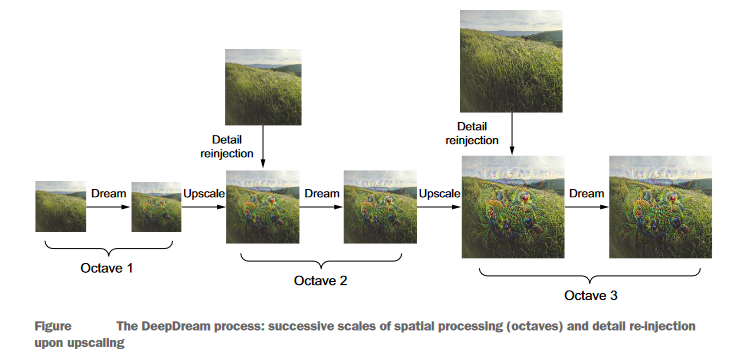

We  define  the  parameters  of  this  process  in  the  following  code.  Tweaking  these parameters will allow you to achieve new effects.

In [6]:
step = 20.                                                                      # Gradient ascent step size.
num_octave = 3                                                                  # Number of scales at which to run gradient ascent.
octave_scale = 1.4                                                              # Size ratio between successive scales.
iterations = 30                                                                 # Number of gradient ascent steps per scale.
max_loss = 15.                                                                  # We’ll stop the gradient ascent process for.
                                                                                # a scale if the loss gets higher than this.

We're also going to need a couple of <font color='blue'>utility functions</font> to <font color='blue'>load</font> and <font color='blue'>save images</font>.

**Image processing utilities**

In [7]:
import numpy as np

def preprocess_image(image_path):                                               # Util function to open, resize,and format pictures into
    img = keras.utils.load_img(image_path)                                      # appropriate arrays.
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):                                                       # Util function to convert a NumPy array into a valid image.
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0                                                                  # Undo inception v3 preprocessing.
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")                                  # Convert to uint8 and clip to the valid range [0, 255].
    return img

This is the outer loop. To <font color='blue'>avoid losing</font> a <font color='blue'>lot of image detail</font> after each successive scale-up  (resulting  in  increasingly  blurry  or  pixelated  images),  we  can  use  a  <font color='blue'>straightforward  trick</font>: after each scale-up, we'll <font color='blue'>re-inject</font> the <font color='blue'>lost details back</font> into the <font color='blue'>image</font>, which is possible because we know what the original image should look like at the larger scale. Given a small image size S and a larger image size L, we can compute the difference between the original image resized to size L and the original resized to size S—this difference quantifies the details lost when going from S to L.

**Running gradient ascent over multiple successive "octaves"**

In [8]:
original_img = preprocess_image(base_image_path)                                # Load the test image.
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):                                                  # Compute the target shape of the image at different octaves.
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)                                                 # Make a copy of the image (we need to keep the original around).
for i, shape in enumerate(successive_shapes):                                   # Iterate over the different octaves.
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)                                           # Scale up the dream image.
    img = gradient_ascent_loop(                                                 # Run gradient ascent, altering the dream.
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)  # Scale up the smaller version of the original image: it will be pixellated.
    same_size_original = tf.image.resize(original_img, shape)                   # Compute the high-quality version of the original image at this size.
    lost_detail = same_size_original - upscaled_shrunk_original_img             # The difference between the two is the detail that was lost when scaling up.
    img += lost_detail                                                          # Re-inject lost detail into the dream.
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))                 # Save the final result.

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 2.06
... Loss value at step 1: 2.86
... Loss value at step 2: 3.99
... Loss value at step 3: 4.99
... Loss value at step 4: 5.92
... Loss value at step 5: 6.89
... Loss value at step 6: 7.90
... Loss value at step 7: 9.04
... Loss value at step 8: 10.07
... Loss value at step 9: 11.09
... Loss value at step 10: 12.27
... Loss value at step 11: 13.11
... Loss value at step 12: 14.34
Processing octave 1 with shape (642, 857)
... Loss value at step 0: 3.52
... Loss value at step 1: 5.89
... Loss value at step 2: 7.62
... Loss value at step 3: 9.00
... Loss value at step 4: 10.15
... Loss value at step 5: 11.35
... Loss value at step 6: 12.45
... Loss value at step 7: 13.47
... Loss value at step 8: 14.57
Processing octave 2 with shape (900, 1200)
... Loss value at step 0: 3.35
... Loss value at step 1: 5.39
... Loss value at step 2: 6.79
... Loss value at step 3: 7.92
... Loss value at step 4: 8.95
... Loss value at step 

**Remark:** Because the <font color='blue'>original Inception V3</font> network was trained to recognize concepts in <font color='blue'>images</font> of <font color='blue'>size 299 × 299</font>, and given that the process involves scaling the images down by a reasonable factor, the DeepDream implementation produces <font color='blue'>much better results</font> on images that are somewhere between <font color='blue'>300 × 300</font> and <font color='blue'>400 × 400</font>. Regardless, you can run the same code on images of any size and any ratio.

On a GPU, it only takes a few seconds to run the whole thing. The Figure below shows the result of our dream configuration on the test image.

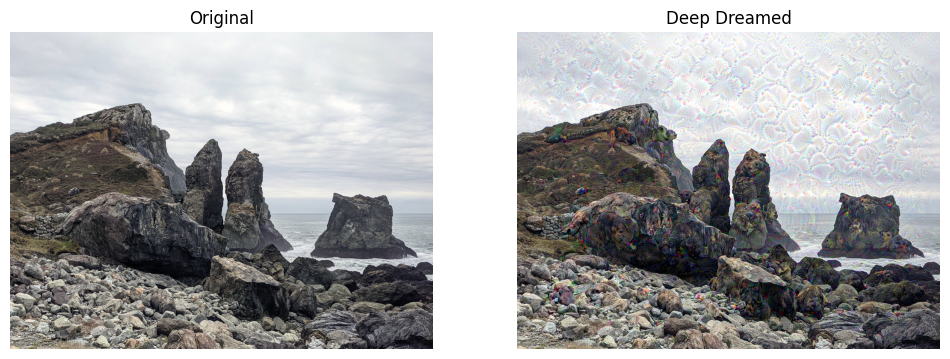

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.axis("off")
plt.title('Original')
plt.imshow(keras.utils.load_img(base_image_path))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title('Deep Dreamed')
plt.imshow(keras.utils.load_img("dream.png"))

I strongly suggest that you <font color='blue'>explore</font> what you can do by <font color='blue'>adjusting which layers</font> you use in your <font color='blue'>loss</font>. Layers that are <font color='blue'>lower</font> in the network contain <font color='blue'>more-local, less-abstract</font> representations and lead to dream patterns that look more geometric. Layers that are <font color='blue'>higher</font> up lead to <font color='blue'>more-recognizable visual patterns</font> based on the most common objects found in ImageNet, such as dog eyes, bird feathers, and so on. You can use <font color='blue'>random generation</font>  of  the  <font color='blue'>parameters</font>  in  the  <font color='blue'>layer_settings  dictionary</font>  to  quickly  explore  many different layer combinations. The Figure below shows a range of results obtained on an image
of a delicious homemade pastry using different layer configurations.

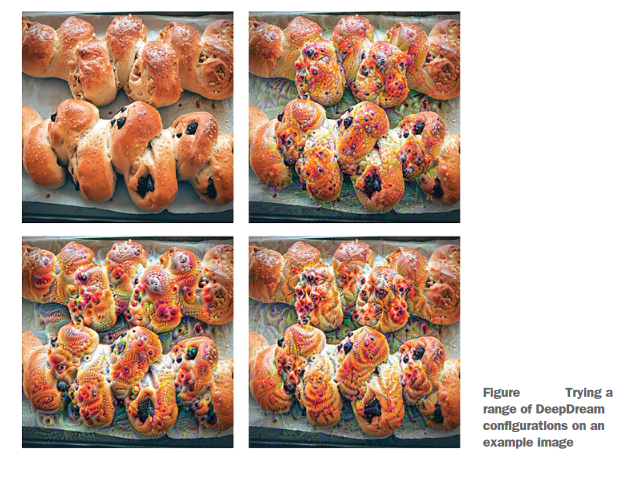

Another example is a picture of mountains on a sunny day.

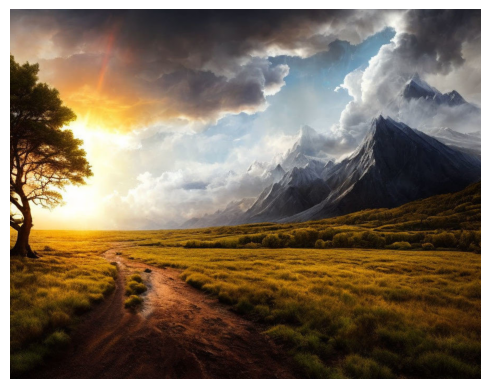

In [10]:
base_image_path_mountain = keras.utils.get_file(
    "mountain.jpg", origin="https://d1joui61864gj3.cloudfront.net/1177409/rw3kwa_4da99baae5845e9d708022e6834a58daa1d8e32c.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path_mountain))

You can first tweak the parameters.

In [20]:
step = 20.                                                                      # Gradient ascent step size.
num_octave = 6                                                                  # Number of scales at which to run gradient ascent.
octave_scale = 1.3                                                             # Size ratio between successive scales.
iterations = 40                                                                 # Number of gradient ascent steps per scale.
max_loss = 20.                                                                  # We’ll stop the gradient ascent process for.
                                                                                # a scale if the loss gets higher than this.

**Then run gradient ascent over multiple successive "octaves"**

In [21]:
original_img = preprocess_image(base_image_path_mountain)                       # Load the test image.
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):                                                  # Compute the target shape of the image at different octaves.
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)                                                 # Make a copy of the image (we need to keep the original around).
for i, shape in enumerate(successive_shapes):                                   # Iterate over the different octaves.
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)                                           # Scale up the dream image.
    img = gradient_ascent_loop(                                                 # Run gradient ascent, altering the dream.
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)  # Scale up the smaller version of the original image: it will be pixellated.
    same_size_original = tf.image.resize(original_img, shape)                   # Compute the high-quality version of the original image at this size.
    lost_detail = same_size_original - upscaled_shrunk_original_img             # The difference between the two is the detail that was lost when scaling up.
    img += lost_detail                                                          # Re-inject lost detail into the dream.
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("mountain.png", deprocess_image(img.numpy()))                 # Save the final result.

Processing octave 0 with shape (189, 241)
... Loss value at step 0: 2.67
... Loss value at step 1: 3.26
... Loss value at step 2: 4.22
... Loss value at step 3: 5.18
... Loss value at step 4: 6.72
... Loss value at step 5: 7.92
... Loss value at step 6: 9.08
... Loss value at step 7: 10.50
... Loss value at step 8: 12.02
... Loss value at step 9: 12.72
... Loss value at step 10: 14.22
... Loss value at step 11: 15.45
... Loss value at step 12: 17.70
... Loss value at step 13: 18.60
Processing octave 1 with shape (246, 313)
... Loss value at step 0: 4.24
... Loss value at step 1: 7.43
... Loss value at step 2: 9.92
... Loss value at step 3: 11.78
... Loss value at step 4: 13.65
... Loss value at step 5: 15.53
... Loss value at step 6: 17.74
... Loss value at step 7: 19.24
Processing octave 2 with shape (320, 407)
... Loss value at step 0: 4.37
... Loss value at step 1: 7.52
... Loss value at step 2: 10.02
... Loss value at step 3: 12.05
... Loss value at step 4: 14.10
... Loss value at 

The Figure below shows the result of our dream configuration on the mountain test image.

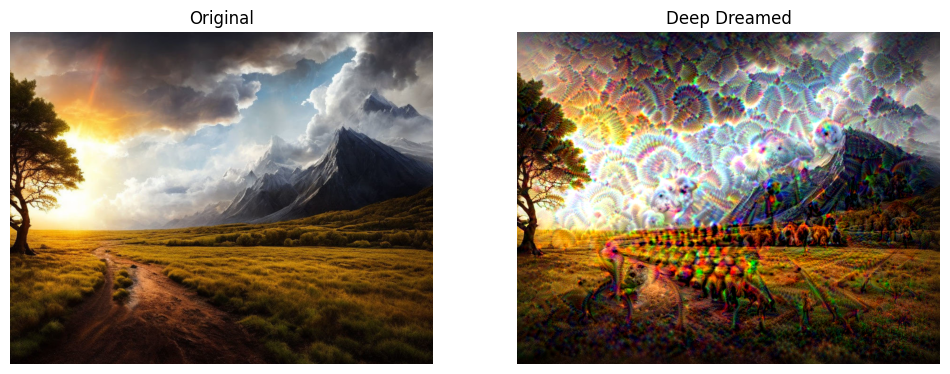

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.axis("off")
plt.title('Original')
plt.imshow(keras.utils.load_img(base_image_path_mountain))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title('Deep Dreamed')
plt.imshow(keras.utils.load_img("mountain.png"))

### Wrapping up

* DeepDream consists of running a <font color='blue'>convnet in reverse</font> to generate inputs based on the representations learned by the network.
* The  results  produced  are  fun  and  somewhat  similar  to  the  visual  artifacts induced in humans by the disruption of the visual cortex via psychedelics.
* Note that the process <font color='blue'>isn't specific</font> to <font color='blue'>image models</font> or even to <font color='blue'>convnets</font>. It can be done for <font color='blue'>speech, music, and more</font>.